# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021-2022. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet.
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
!pip install --upgrade gensim 

     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Some imports for the notebook to work
import re
import time
import copy
import itertools
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# sklearn imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

# LightGBM
import lightgbm as lgb
from lightgbm import log_evaluation

# Word2Vec
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [ ]:
# raw_df = pd.read_parquet('./metrolyrics.parquet')
raw_df = pd.read_parquet(
    "/content/drive/MyDrive/Y-Data/Semester II/Deep Learning/Assignments/Assignment 8 - Word Embedding + Text Classification/data/metrolyrics.parquet"
)

In [7]:
raw_df.shape

(49976, 8)

In [8]:
print(raw_df.iloc[0].lyrics)
print(raw_df.iloc[0].sent)

[HEALY]
[spoken] This is Bert Healy saying ...
[singing now] Hey, hobo man
Hey, Dapper Dan
You've both got your style
But Brother,
You're never fully dressed
Without a smile!
Your clothes may be Beau Brummelly
They stand out a mile --
But Brother,
You're never fully dressed
Without a smile!
Who cares what they're wearing
On Main Street,
Or Saville Row,
It's what you wear from ear to ear
And not from head to toe
(That matters)
So, Senator,
So, Janitor,
So long for a while
Remember,
You're never fully dressed
Without a smile!
[BOYLAN SISTER]
Ready or not, here he goes
Listen to Bert
Tap his smilin' toes
[HEALY]
[spoken] Ah, the lovely Boylan Sisters
[BOYLAN SISTERS]
Doo doodle-oo doo
Doo doodle-oo doo
Doo doo doo doo
Doo doo doo doo
Your clothes may be Beau Brummelly
They stand out a mile
But, bother
You're never fully dressed
You're never dressed
Without an
[CONNIE BOYLAN]
S-
[BONNIE BOYLAN]
M-
[RONNIE BOYLAN]
I-
[CONNIE BOYLAN]
L-
[ALL THREE]
E.
Smile darn ya smile.
[ALL]
That matters


In [ ]:
# Download the stopwords and word tokenizer from nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [ ]:
def preprocess_words(raw_str):
    # 1. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", raw_str)

    # 2. Convert to lower case, tokenize into individual words
    words = word_tokenize(letters_only.lower())

    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))

    # 4. Remove stop words
    tokenized_words = [w for w in words if not w in stops]

    return tokenized_words


def preprocess_df(df, cols_to_process):
    for col in cols_to_process:
        df[f"{col}_preprocessed"] = df[col].map(lambda x: preprocess_words(x))
    return df


In [ ]:
pp_df = preprocess_df(raw_df, ["lyrics", "sent"])
pp_df.iloc[0]

song                                                       fully-dressed
year                                                                2008
artist                                                             annie
genre                                                                Pop
lyrics                 [HEALY]\n[spoken] This is Bert Healy saying .....
num_chars                                                           1041
sent                   healy spoken this bert healy saying singing he...
num_words                                                            826
lyrics_preprocessed    [healy, spoken, bert, healy, saying, singing, ...
sent_preprocessed      [healy, spoken, bert, healy, saying, singing, ...
Name: 204182, dtype: object

In [ ]:
def train_word2vec(
    df,
    col_name,
    num_features=300,
    min_word_count=20,
    context=10,
    downsampling=1e-3,
    num_workers=multiprocessing.cpu_count() - 1,
):
    """Trains word2vec model and returns model given input model hyper params and a dataframe

    Params:
        num_features      # Word vector dimensionality
        min_word_count    # Minimum word count
        num_workers       # Number of threads to run in parallel
        context           # Context window size (How many words of context should the training algorithm take into account?)
        downsampling      # Downsample setting for frequent words

    Returns:
        trained word2vec model
    """

    model = Word2Vec(
        df[col_name].tolist(),
        workers=num_workers,
        vector_size=num_features,
        min_count=min_word_count,
        window=context,
        sample=downsampling,
    )

    model.save(f"./models/word2vec_model_context_{context}.bin")
    return model

In [ ]:
model_ct10 = Word2Vec.load(
    "/content/drive/MyDrive/Y-Data/Semester II/Deep Learning/Assignments/Assignment 8 - Word Embedding + Text Classification/models/word2vec_model_context_10.bin"
)

In [ ]:
model_ct10 = train_word2vec(
    pp_df, "lyrics_preprocessed", num_features=300, min_word_count=20, context=10
)
model_ct20 = train_word2vec(
    pp_df, "lyrics_preprocessed", num_features=300, min_word_count=20, context=20
)
model_ct50 = train_word2vec(
    pp_df, "lyrics_preprocessed", num_features=300, min_word_count=20, context=50
)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [ ]:
(
    model_ct10.wv.most_similar("love"),
    model_ct20.wv.most_similar("love"),
    model_ct50.wv.most_similar("love"),
)

([('darling', 0.5546019077301025),
  ('darlin', 0.5225796699523926),
  ('heart', 0.522108256816864),
  ('tender', 0.518748939037323),
  ('babe', 0.5055550336837769),
  ('loving', 0.5044670701026917),
  ('baby', 0.5038967132568359),
  ('lovin', 0.48372310400009155),
  ('true', 0.48206761479377747),
  ('kisses', 0.47537729144096375)],
 [('heart', 0.5101732611656189),
  ('tender', 0.5059552788734436),
  ('darling', 0.4796719253063202),
  ('kisses', 0.4772131145000458),
  ('cherish', 0.46327292919158936),
  ('darlin', 0.4616938829421997),
  ('lovin', 0.4494415521621704),
  ('baby', 0.4488314390182495),
  ('lovers', 0.4419877231121063),
  ('touches', 0.4372428059577942)],
 [('amour', 0.42904531955718994),
  ('heartaches', 0.4276977777481079),
  ('uuuh', 0.40588611364364624),
  ('kisses', 0.4046306908130646),
  ('heart', 0.3959047198295593),
  ('waterfall', 0.39109283685684204),
  ('touches', 0.38264089822769165),
  ('lovers', 0.38034915924072266),
  ('chanterai', 0.3773213028907776),
  ('hu

In [ ]:
(
    model_ct10.wv.most_similar("dance"),
    model_ct20.wv.most_similar("dance"),
    model_ct50.wv.most_similar("dance"),
)

([('dancing', 0.6114360690116882),
  ('romance', 0.5745452046394348),
  ('floor', 0.49271276593208313),
  ('dancin', 0.48856449127197266),
  ('trance', 0.4882347583770752),
  ('chance', 0.44438791275024414),
  ('rhythm', 0.44105562567710876),
  ('groove', 0.41764578223228455),
  ('disco', 0.4095568060874939),
  ('wallflower', 0.4090960621833801)],
 [('trance', 0.5780401825904846),
  ('romance', 0.5765436291694641),
  ('dancing', 0.5555717945098877),
  ('floor', 0.4660272002220154),
  ('dancin', 0.4538261294364929),
  ('chance', 0.44598546624183655),
  ('pants', 0.4259847402572632),
  ('wiggle', 0.42041534185409546),
  ('tanz', 0.4161594808101654),
  ('danse', 0.4042186737060547)],
 [('trance', 0.5151521563529968),
  ('romance', 0.4875383973121643),
  ('dancing', 0.4259102940559387),
  ('pants', 0.41126587986946106),
  ('chance', 0.3996368646621704),
  ('dancefloor', 0.39251840114593506),
  ('dancers', 0.3867315351963043),
  ('wiggle', 0.3763308823108673),
  ('groove', 0.364644914865493

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

##### 1. Evaluate few vector algebra terms

In [ ]:
model_ct10.wv.most_similar(positive=["woman", "king"], negative=["man"], topn=3)

[('queen', 0.6247684359550476),
 ('crown', 0.5356820821762085),
 ('kings', 0.48747020959854126)]

In [ ]:
model_ct10.wv.most_similar(positive=["man", "woman"], topn=3)

[('understands', 0.49320459365844727),
 ('understand', 0.4713032841682434),
 ('plan', 0.4375264346599579)]

In [ ]:
model_ct10.wv.most_similar(positive=["woman", "ring"], topn=3)

[('diamond', 0.5429523587226868),
 ('wedding', 0.5338956117630005),
 ('rings', 0.49342846870422363)]

##### 2. Try to use the Cosine distance and compare it to the Euclidean distance
I'll try to look on a couple of terms and evaluate the different distance measures

In [ ]:
def eval_euc(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)


def eval_cosine(vec1, vec2):
    return np.dot(vec1, vec2) / np.linalg.norm(vec1) * np.linalg.norm(vec2)


In [ ]:
vectors_dict = {
    "dog": model_ct10.wv["dog"],
    "wolf": model_ct10.wv["wolf"],
    "cat": model_ct10.wv["cat"],
    "tiger": model_ct10.wv["tiger"],
    "lion": model_ct10.wv["lion"],
    "friend": model_ct10.wv["friend"],
    "animal": model_ct10.wv["animal"],
}


# Euclidean distance
print(f"Euclidean distance (dog vs. others):")

for key in vectors_dict.keys():
    euc = eval_euc(vectors_dict.get("dog"), vectors_dict.get(key))
    print(f"dog vs. {key} - {euc}")


# Cosine distance
print(f"\nCosine similarity (dog vs. others):")

for key in vectors_dict.keys():
    cosine = eval_cosine(vectors_dict.get("dog"), vectors_dict.get(key))
    print(f"dog vs. {key} - {cosine}")


Euclidean distance (dog vs. others):
dog vs. dog - 0.0
dog vs. wolf - 1.3139185905456543
dog vs. cat - 0.9752369523048401
dog vs. tiger - 1.246208906173706
dog vs. lion - 1.2728004455566406
dog vs. friend - 1.3373481035232544
dog vs. animal - 1.2492549419403076

Cosine similarity (dog vs. others):
dog vs. dog - 0.9999998211860657
dog vs. wolf - 0.1368088722229004
dog vs. cat - 0.5244563221931458
dog vs. tiger - 0.2234816551208496
dog vs. lion - 0.18998944759368896
dog vs. friend - 0.10575001686811447
dog vs. animal - 0.21968096494674683


We can see that cosine similarity has highest similarity when we have a value of 1.
For euclidean, the lower the value the closest the terms are.

We see that for both measures, dogs and cats are the closest to one another (excluding dog vs. dog of course), the ranks are pretty similar.

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [ ]:
# Downloaded & extracted from - "http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SCL-OPP.zip"
sentiment_df = pd.read_csv(
    "./data/SCL-OPP/SCL-OPP.txt", sep="\t", names=["term", "score", "classes", "na"]
)
sentiment_df.term = sentiment_df.term.replace("#", "", regex=True)  # remove hashtags
sentiment_df[["term", "score"]]

,term,score
0,seriously great,1.000
1,ridiculously happy,1.000
2,amazing,1.000
3,pretty damn amazing,0.969
4,happiness overload,0.969
...,...,...
1173,feel like crap,-0.984
1174,friend died,-0.984
1175,died,-0.984
1176,dying,-0.984


In [ ]:
def get_word_sentiment_score(word, df=sentiment_df):
    # since we have multiple words in a term, we need to split them, let's take average of scores per term
    matches_score = np.average(df.loc[df.term.str.contains(word), "score"])
    return matches_score


sentiment_vectors = []

# Take all terms that exist in the sentiment lexicon and create a vector for each
terms = list(
    itertools.chain.from_iterable(
        [t.split(" ") for t in sentiment_df.term.unique().tolist()]
    )
)

for term in terms:
    if term in model_ct10.wv.key_to_index:
        sentiment_vectors.append(
            (term, model_ct10.wv[term].copy(), get_word_sentiment_score(term))
        )

terms_series = pd.Series([t[0] for t in sentiment_vectors])
vectors = [t[1] for t in sentiment_vectors]
scores_series = pd.Series([t[2] for t in sentiment_vectors])

# Create the raw training dataset
terms_dataset = pd.DataFrame(vectors)
terms_dataset = terms_dataset.add_prefix("feature_")
terms_dataset["term"] = terms_series
terms_dataset["score"] = scores_series
terms_dataset.reset_index(drop=True, inplace=True)
terms_dataset


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,term,score
0,-0.028028,-0.026121,0.020629,0.096290,0.025586,0.019924,0.022601,0.051900,0.047586,-0.092528,...,0.084885,0.064383,0.108877,0.099123,0.007190,-0.013950,0.027854,0.094750,seriously,0.521600
1,0.066105,0.078202,0.046873,-0.059407,-0.033094,0.071607,-0.028125,-0.046075,-0.072798,-0.056521,...,-0.018597,-0.127197,0.025826,0.054409,0.034031,-0.007452,0.090128,0.123656,great,0.086000
2,0.139205,-0.047640,0.034289,-0.064284,0.079941,-0.049679,0.064196,0.037481,-0.003611,-0.028626,...,-0.000811,-0.009932,-0.025615,-0.038089,-0.067557,0.029617,-0.103326,-0.007268,happy,0.553889
3,0.020647,-0.157765,0.009216,-0.017624,-0.090399,0.081558,0.110926,-0.119540,-0.039845,0.006473,...,-0.060491,-0.062215,-0.036442,0.024986,0.057815,-0.106348,-0.053494,0.009035,amazing,0.942667
4,0.071866,-0.147105,-0.075780,0.043966,0.097767,0.156751,0.115728,-0.005745,-0.059449,-0.006443,...,0.120305,-0.035822,-0.036112,-0.010153,0.039897,0.099760,-0.074045,-0.005742,pretty,0.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,-0.010248,-0.080916,0.002792,0.013408,0.055824,0.126896,-0.100063,-0.062407,0.011026,-0.028788,...,-0.099800,-0.036279,-0.044897,0.035017,0.055190,0.092987,0.096041,0.011879,died,-0.800500
1711,-0.010248,-0.080916,0.002792,0.013408,0.055824,0.126896,-0.100063,-0.062407,0.011026,-0.028788,...,-0.099800,-0.036279,-0.044897,0.035017,0.055190,0.092987,0.096041,0.011879,died,-0.800500
1712,-0.060548,-0.041983,0.003192,0.085494,-0.055444,-0.048816,0.008712,-0.069092,0.051438,0.041116,...,-0.072540,-0.046278,-0.012012,0.059694,0.119759,0.104539,0.045411,0.024458,dying,-0.773500
1713,-0.023271,0.052785,0.085583,-0.037365,0.088260,0.020265,-0.014079,0.029515,0.058895,-0.044170,...,0.076155,0.133354,-0.002555,0.090741,0.021676,-0.079883,0.002854,0.034250,sucks,-0.786500


In [ ]:
dataset_x = terms_dataset[[c for c in terms_dataset.columns.tolist() if c != "score"]]
dataset_y = terms_dataset.score

# Train test split
X_full_train, X_test, y_full_train, y_test = train_test_split(
    dataset_x, dataset_y, test_size=0.1, random_state=42
)  # Train test 90% / 10% split

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.1, random_state=42
)  # 90% / 10% split

In [ ]:
# Train a simple light gbm model

# training features (vector only)
train_features = [c for c in dataset_x.columns.tolist() if c not in ["term", "score"]]

# Params set after playing with them a little bit
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "random_state": 42,
    "n_estimators": 300,
}

regressor = lgb.LGBMRegressor(**lgb_params)


reg_lgb = regressor.fit(
    X_train[train_features],
    y_train,
    eval_set=[(X_train[train_features], y_train), (X_val[train_features], y_val)],
    eval_names=["train", "val"],
    eval_metric="l2",
    early_stopping_rounds=10,
    callbacks=[log_evaluation(1)],
    verbose=10,
)


[1]	train's l2: 0.134793	val's l2: 0.141105
[2]	train's l2: 0.129456	val's l2: 0.136058
[3]	train's l2: 0.124322	val's l2: 0.130981
[4]	train's l2: 0.119495	val's l2: 0.126585
[5]	train's l2: 0.114788	val's l2: 0.121966
[6]	train's l2: 0.110121	val's l2: 0.117623
[7]	train's l2: 0.105821	val's l2: 0.113298
[8]	train's l2: 0.101788	val's l2: 0.109239
[9]	train's l2: 0.0977065	val's l2: 0.105424
[10]	train's l2: 0.0939886	val's l2: 0.101795
[10]	train's l2: 0.0939886	val's l2: 0.101795
[11]	train's l2: 0.0904445	val's l2: 0.0981708
[12]	train's l2: 0.0868327	val's l2: 0.094672
[13]	train's l2: 0.0835315	val's l2: 0.0913732
[14]	train's l2: 0.0803179	val's l2: 0.0882744
[15]	train's l2: 0.0773853	val's l2: 0.0855069
[16]	train's l2: 0.0744262	val's l2: 0.0830121
[17]	train's l2: 0.0715988	val's l2: 0.0799729
[18]	train's l2: 0.0689133	val's l2: 0.0775297
[19]	train's l2: 0.0663079	val's l2: 0.0749235
[20]	train's l2: 0.0638285	val's l2: 0.0727971
[20]	train's l2: 0.0638285	val's l2: 0.072

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

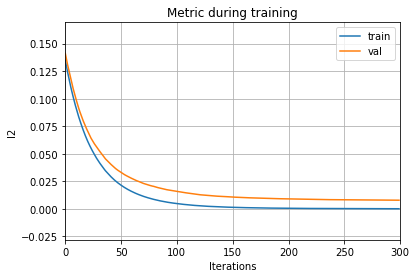

In [ ]:
lgb.plot_metric(reg_lgb)

In [ ]:
preds_train = reg_lgb.predict(X_full_train[train_features])
preds_test = reg_lgb.predict(X_test[train_features])

In [ ]:
mean_squared_error(y_full_train, preds_train), mean_squared_error(y_test, preds_test)

(0.0009562578361092441, 0.005367143974344895)

In [ ]:
preds_test[:10], y_test[:10].values

(array([ 0.14144686, -0.51537524, -0.53899095, -0.33030881, -0.31243768,
        -0.13367586,  0.07408348, -0.36632367,  0.09544715,  0.07397952]),
 array([ 0.14184615, -0.5155    , -0.53916667, -0.332125  , -0.1875    ,
        -0.13614286,  0.0814    , -0.36644444,  0.0966    ,  0.0935    ]))

We can see that the training was decent, and we got similar results (and even slightly better) in the validation vs. test sets as expected.

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [ ]:
vocab = model_ct10.wv.index_to_key
vocab_not_in_sentiment = [t for t in vocab if t not in terms_dataset.term.tolist()]
vocab_not_in_sentiment[:5]

['know', 'get', 'na', 'oh', 'go']

In [ ]:
len(terms_dataset.term.tolist())

1715

In [ ]:
len(vocab_not_in_sentiment)

17598

In [ ]:
vocab_not_in_sentiment_vectors = []

for term in vocab_not_in_sentiment:
    vocab_not_in_sentiment_vectors.append((term, model_ct10.wv[term].copy()))

terms_series = pd.Series([t[0] for t in vocab_not_in_sentiment_vectors])
vectors = [t[1] for t in vocab_not_in_sentiment_vectors]

# Create a df for the above terms
df_non_sentiment = pd.DataFrame(vectors)
df_non_sentiment = df_non_sentiment.add_prefix("feature_")
df_non_sentiment["term"] = terms_series
df_non_sentiment.reset_index(drop=True, inplace=True)
df_non_sentiment.drop_duplicates(inplace=True)
df_non_sentiment

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,term
0,-0.015594,-0.151872,0.038145,0.066232,-0.041002,0.044251,-0.012163,-0.078920,0.046068,0.066331,...,-0.018206,-0.088872,-0.028217,0.014799,0.075330,-0.014880,0.037611,-0.079285,-0.050155,know
1,0.066580,-0.038033,-0.097735,-0.055585,0.000928,0.092358,0.024209,-0.037367,0.033208,0.058306,...,-0.011908,0.073914,0.012582,-0.019268,-0.049519,0.033323,0.078102,-0.052163,-0.075462,get
2,-0.037741,-0.064735,0.059322,-0.032395,0.038685,-0.067817,-0.047337,0.022609,0.017045,0.041497,...,-0.011698,0.061977,-0.068375,-0.010110,-0.051013,0.011208,-0.021238,-0.006375,-0.001417,na
3,0.046028,-0.123302,-0.099132,-0.011605,0.051638,0.064881,-0.013577,0.003608,-0.054244,0.013279,...,-0.000817,-0.010521,0.026977,0.014814,-0.029721,0.002991,0.088782,-0.035121,-0.002007,oh
4,0.008736,-0.130506,-0.024540,0.036616,-0.099107,0.003834,0.031658,0.061613,-0.021749,-0.007907,...,0.021194,-0.029272,-0.101153,-0.038239,-0.072871,-0.004116,0.076480,-0.014726,0.046490,go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17593,-0.041834,0.135116,0.051019,-0.003632,0.008018,-0.105791,-0.006312,0.178408,-0.041670,-0.088289,...,0.077802,0.024484,0.035562,0.161827,0.000574,0.020291,-0.069425,-0.003620,-0.013329,kol
17594,-0.015684,0.065527,0.047127,-0.009311,0.005532,-0.071698,0.001019,0.117850,0.003317,-0.109556,...,0.022155,0.001333,-0.004457,0.052779,-0.032595,0.052834,-0.048906,-0.042078,-0.008774,eik
17595,0.022189,0.099821,-0.010121,-0.014739,-0.064228,-0.042072,0.127514,0.065494,0.059785,-0.110912,...,0.045825,0.042692,0.048477,-0.013250,0.101049,0.079249,-0.065377,0.040116,0.032708,cadence
17596,0.004386,0.089870,-0.029209,0.071973,0.088566,-0.058286,-0.005937,0.158389,-0.037349,-0.080670,...,0.001027,-0.022631,0.107562,0.086484,0.036371,0.035226,-0.019244,-0.044727,-0.074940,ane


In [ ]:
df_non_sentiment["pred"] = reg_lgb.predict(df_non_sentiment[train_features])

In [ ]:
print("Top negative terms:")
df_non_sentiment.sort_values(by="pred", ascending=True)[["term", "pred"]].head(10)

Top negative terms:


,term,pred
12334,leech,-0.738844
3748,tortured,-0.729193
3722,doomed,-0.710140
2979,destroyed,-0.708255
2305,feeding,-0.691712
4208,stench,-0.688690
14059,molested,-0.657111
6395,bloodshed,-0.653054
4490,anguish,-0.651299
1093,bleeding,-0.645901


In [ ]:
print("Top positive terms:")
df_non_sentiment.sort_values(by="pred", ascending=False)[["term", "pred"]].head(10)

Top positive terms:


,term,pred
2241,heavenly,0.638363
14036,cutest,0.623009
1295,tender,0.579830
4540,mmmm,0.578129
8904,judy,0.568874
14169,evergreen,0.562289
11399,cheering,0.551869
1758,sunny,0.546642
15915,raindrop,0.545945
5339,waltz,0.543667


These terms seem to definitely make sense, let's verify they were not a part of the sentiment corpus as results looks too good :)

In [ ]:
[i for i in df_non_sentiment.term.tolist() if i in terms_dataset.term.tolist()]

[]

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. You are encouraged to try that color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [ ]:
genres = raw_df.genre.unique().tolist()
genres

['Pop', 'Hip-Hop', 'Rock', 'Country', 'Metal']

In [ ]:
words = []

for song_lyrics in raw_df.lyrics.tolist():
    words.extend(preprocess_words(song_lyrics))

In [ ]:
clean_sentences = [remove_stopwords(song) for song in raw_df.sent]
song_tokens = list(model_ct10.wv.key_to_index.keys())
song_tokens_count = [model_ct10.wv.get_vecattr(token, "count") for token in song_tokens]
song_tokens_count_series = pd.Series(data=song_tokens_count, index=song_tokens)
top_3000_tokens = list(
    song_tokens_count_series.sort_values(ascending=False)[:3000].index
)


# create dataframe with 5 genres as columns and 3K words as rows, to store the results
genres = pp_df.genre.value_counts().index
count_df = pd.DataFrame(
    index=top_3000_tokens, columns=genres, data=np.zeros((3000, len(genres)))
)

# count only the relevant tokens
cvectorizer = CountVectorizer(vocabulary=top_3000_tokens)
count_matrix = cvectorizer.fit_transform(
    clean_sentences
).toarray()  # create a 49976 x 3000 matrix with token counts for each song

# summarize the counts and frequency per genre and save it
for genre in genres:
    genre_mask = raw_df.genre == genre  # find only records for the current genre
    token_counts = count_matrix[genre_mask, :].sum(
        axis=0
    )  # sum counts in all songs of this genre
    count_df[genre] = token_counts  # store the results in a relevant column in df

freq_df = count_df / count_df.sum()  # create a df frequency counts


In [ ]:
# Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus
total_word_counts = count_df.sum(axis=1)
total_word_freqs = total_word_counts / total_word_counts.sum()
total_word_freqs_arr = total_word_freqs.values.reshape(-1, 1)

# replace zero counts to avoid division by 0
total_word_freqs_arr = np.where(
    total_word_freqs_arr > 0, total_word_freqs_arr, np.finfo(np.float32).eps
)
relative_freq_df = freq_df / total_word_freqs_arr
relative_freq_df.head()

,Rock,Pop,Hip-Hop,Metal,Country
like,0.792242,0.852872,1.344810,0.574529,0.865371
know,1.103257,1.226743,0.979630,0.558907,0.966573
got,0.830654,0.953784,1.343003,0.347313,0.869407
love,1.058566,1.770504,0.514150,0.463960,1.693442
get,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Pick the top 50 words for each genre (we assume that we use the relative frequency for this, and not regular frequency or absolute counts).
# Join the words from all genres into a single list of top significant words.

top_words = {}  # dict for storing top words per ganre
for genre in genres:
    top50 = list(relative_freq_df[genre].sort_values(ascending=False).index[:50])
    print(genre, ":\n", *top50, "\n")
    top_words[genre] = top50

# all top words
all_top_words = [word for lst in top_words.values() for word in lst]
all_top_words_vectors = [model_ct10.wv[word] for word in all_top_words]

Rock :
 vocals pum jeg kimi ga wa bop ik american wasted crawling ordinary wasting desperate johnny crashing changing rum drums strangers wolf sinking blues doll greater sings troubles floating hiding tiny sets liar anymore doo voc ooo dive bridges electric poison weep waited waking mistakes aching says changes angry finding closing 

Pop :
 nae amore coraz amor bu luna amour piel alma io nan che contigo tes sempre feliz cada pi ti tus quand rien moi mia tanto mio sentir cosa ce puede sans dolor vez puedo toi dentro siento mai wah qui eres eh cielo vie cuerpo quiero algo non hoy tout 

Hip-Hop :
 mayne eazy dre versace chamillionaire yuh pac eminem mek niggas gangsta compton wid nuttin aight rappers nigga niggaz trill hoes feds motherfuckin glock biggie rep bitches ballin thugs thug dawg clique finna killa inna yall busta homies moms gat hustler rims pussy dogg beef nuh homie naw benz pimpin haters 

Metal :
 corpse decay chaos mortal existence eternal wrath mankind agony sword gods an

/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


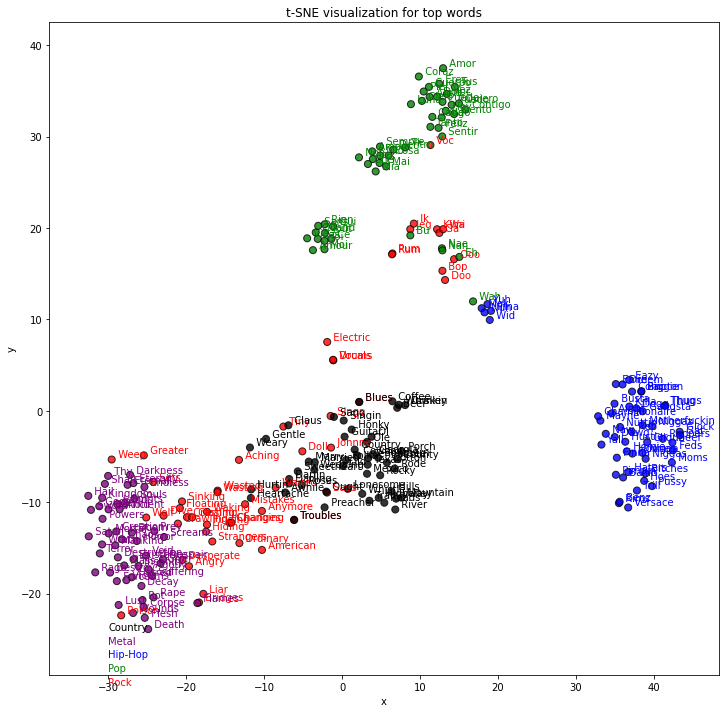

In [ ]:
def tsnescatterplot(word_labels, vectors, generes):
    # create a list of 250 colors, 50 similiar colors for each genre words
    color_list = []
    genre_colors = ["red", "green", "blue", "purple", "black"]
    for color in genre_colors:
        color_list.append([color] * 50)
    color_list = [color for lst in color_list for color in lst]  # flatten the list

    # Reduce the dimensionality from 300 to 50 dimensions with PCA (as suggestet in the t-SNE paper)
    reduc = PCA(n_components=50).fit_transform(vectors)

    # Find t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame(
        {
            "x": [x for x in Y[:, 0]],
            "y": [y for y in Y[:, 1]],
            "words": word_labels,
            "color": color_list,
        }
    )

    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)

    # Basic plot
    p1 = sns.regplot(
        data=df,
        x="x",
        y="y",
        fit_reg=False,
        marker="o",
        color="k",
        scatter_kws={"s": 50, "facecolors": df["color"]},
    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(
            df["x"][line],
            df["y"][line],
            "  " + df["words"][line].title(),
            horizontalalignment="left",
            verticalalignment="bottom",
            size="medium",
            color=df["color"][line],
            weight="normal",
        ).set_size(10)

    plt.xlim(Y[:, 0].min() - 5, Y[:, 0].max() + 5)
    plt.ylim(Y[:, 1].min() - 5, Y[:, 1].max() + 5)

    # plot legend
    for i, name in enumerate(generes):
        plt.text(-30, 1.5 * i - 30, name, color=genre_colors[i])

    plt.title("t-SNE visualization for top words")


tsnescatterplot(all_top_words, all_top_words_vectors, genres)

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    raw_df.sent, raw_df.genre, test_size=0.2, random_state=42
)  # 80% / 20% split

nb_pipe = Pipeline(
    [
        ("vect", CountVectorizer(max_features=10000, min_df=10, stop_words="english")),
        ("clf", MultinomialNB()),
    ]
)

nb_pipe.fit(X_train, y_train)  # train the pipeline
print(f"Test accuracy is: {nb_pipe.score(X_test, y_test):.3f}")

Test accuracy is: 0.578


Show the confusion matrix.

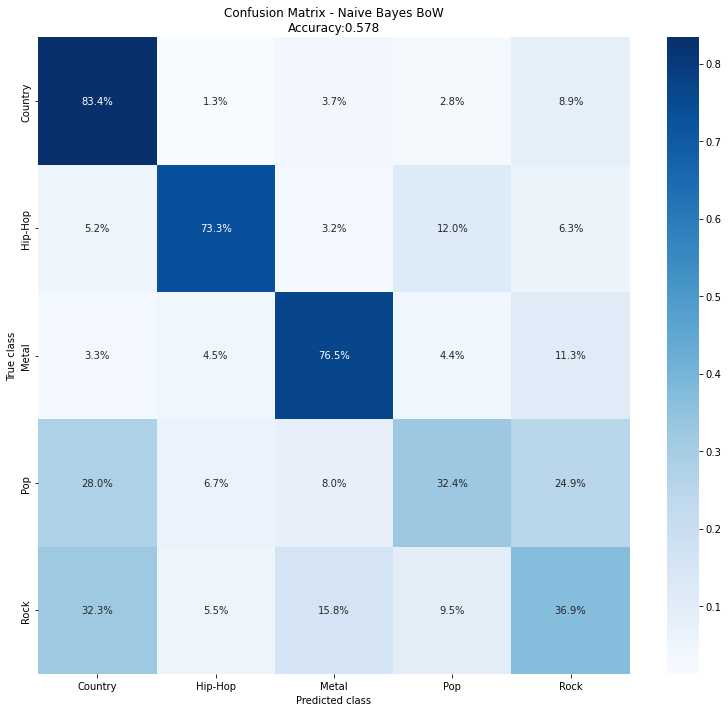

In [ ]:
def draw_cm(y_test, y_pred, classes, title):
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Plotting
    plt.figure(figsize=(11, 10))
    # draw matrix as heatmap, using a small font and blue color map
    sns.heatmap(cm_df, annot=True, fmt=".1%", annot_kws={"fontsize": 10}, cmap="Blues")
    # calc accuracy and show it in the title
    plt.title(title + "\nAccuracy:{0:.3f}".format(accuracy_score(y_test, y_pred)))
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    # formating tick labels (class names)
    plt.gca().axes.tick_params(labelsize="medium")
    plt.tight_layout()


y_pred = nb_pipe.predict(X_test)
draw_cm(y_test, y_pred, nb_pipe.classes_, "Confusion Matrix - Naive Bayes BoW")

Show the classification report - precision, recall, f1 for each class.

In [ ]:
print(classification_report(y_test, y_pred, target_names=nb_pipe.classes_))

              precision    recall  f1-score   support

     Country       0.47      0.83      0.60      1656
     Hip-Hop       0.79      0.73      0.76      1917
       Metal       0.67      0.76      0.72      1828
         Pop       0.55      0.32      0.41      2214
        Rock       0.46      0.37      0.41      2381

    accuracy                           0.58      9996
   macro avg       0.59      0.61      0.58      9996
weighted avg       0.58      0.58      0.56      9996



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [ ]:
def get_mean_vector(words):
    all_vectors = []

    for word in words:
        if word in model_ct10.wv.index_to_key:
            all_vectors.append(model_ct10.wv[word])

    # get the mean vector for the whole text
    mean_vector = np.mean(all_vectors, axis=0)

    return mean_vector

In [ ]:
pp_df["words_avg_vec"] = pp_df.sent_preprocessed.map(lambda x: get_mean_vector(x))

In [ ]:
pp_df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words,lyrics_preprocessed,sent_preprocessed,words_avg_vec
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826,"[healy, spoken, bert, healy, saying, singing, ...","[healy, spoken, bert, healy, saying, singing, ...","[-0.000803147, -0.038829915, 0.006080293, 0.00..."
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884,"[chorus, repeat, x, even, tryin, low, recogniz...","[chorus, repeat, x, even, tryin, low, recogniz...","[-0.024093553, -0.052486792, 0.018396907, -0.0..."
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756,"[could, cause, much, pain, leave, heart, rain,...","[could, cause, much, pain, leave, heart, rain,...","[-0.002381391, -0.07937976, -0.016874831, 0.02..."
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583,"[scarlet, vision, velvet, room, come, decision...","[scarlet, vision, velvet, room, come, decision...","[0.031630293, -0.043687187, -0.03121626, -0.00..."
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,"[sprintime, savannah, dont, get, much, prettie...","[sprintime, savannah, dont, get, much, prettie...","[-0.030062674, -0.057570543, -0.002403161, -0...."


In [ ]:
avg_df = pd.DataFrame(pp_df.words_avg_vec.tolist())
avg_df = avg_df.add_prefix("feature_")
avg_df["song"] = pp_df.song
avg_df["genre"] = pp_df.genre
avg_df["sent"] = pp_df.sent
avg_df.dropna(inplace=True)
avg_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,song,genre,sent
0,-0.000803,-0.038830,0.006080,0.006287,0.004814,0.015455,0.003621,0.031321,-0.001102,-0.018165,...,0.015756,0.003143,0.015798,0.003120,0.021347,-0.015977,-0.017260,ego-remix,Pop,oh baby you know i gon na cut right chase some...
2,-0.002381,-0.079380,-0.016875,0.020629,0.003550,0.056239,-0.003525,-0.044072,-0.000421,0.029009,...,-0.021420,-0.032446,-0.001023,0.000124,0.037878,-0.024765,0.008392,honesty,Pop,if search for tenderness it hard find you love...
7,-0.003648,-0.035006,0.000884,-0.009248,0.007067,0.022187,-0.026849,-0.024375,0.009995,0.010957,...,0.002831,-0.000518,-0.005168,0.006295,0.001513,0.018882,-0.011390,waiting,Pop,waiting waiting waiting waiting waiting waitin...
9,-0.013746,-0.061049,0.004328,0.028394,-0.014619,0.032779,-0.069021,-0.051582,0.024110,0.052591,...,-0.004532,0.023585,-0.006129,-0.049731,-0.008892,-0.004525,0.016320,why-don-t-you-love-me,Pop,n n honey you better sit look around cause mus...
11,0.014213,0.039513,0.000790,0.020958,0.020386,-0.028417,0.070551,0.151831,-0.044345,-0.064211,...,0.026646,0.056817,-0.002223,-0.020643,0.009234,0.026243,-0.017341,telephone,Pop,hello hello baby called i hear thing i got ser...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49961,0.020692,-0.048355,-0.044627,0.029176,-0.005416,-0.021914,0.001095,-0.029048,0.025835,0.016382,...,-0.006777,0.016944,0.031573,0.008254,0.053615,-0.019370,-0.004543,below-zero,Hip-Hop,nokio yo yo something uh old bottle old whine ...
49963,0.017073,-0.090733,-0.040130,-0.007690,0.031156,0.036447,-0.020382,-0.025707,-0.037755,0.022540,...,0.020742,-0.001209,-0.016706,-0.015255,0.048953,-0.010474,-0.015404,sleeping-in-my-bed,Hip-Hop,i got feeling i turn loose that somebody getti...
49964,-0.008381,-0.027527,-0.004213,0.033944,0.009163,0.049712,-0.011622,-0.005331,0.020631,0.018171,...,-0.008473,0.002150,0.004433,-0.008774,0.003411,-0.007615,0.000778,one-good-reason,Hip-Hop,can i talk second got something i want say i r...
49967,-0.008913,-0.042002,-0.005197,0.000950,-0.017776,0.022409,-0.005179,-0.017269,0.008217,0.011315,...,-0.022831,-0.005244,-0.012103,0.001888,0.020684,-0.010340,-0.007018,the-love-we-had-stays-on-my-mind,Hip-Hop,i believe girl i believe but i man ill alright...


In [ ]:
train_features = [c for c in avg_df.columns.tolist() if c.startswith("feature_")]

X_train, X_test, y_train, y_test = train_test_split(
    avg_df, avg_df.genre, test_size=0.1, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Params set after playing with them a little bit
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 42,
    "n_estimators": 100,
}

clf_avg_vec = lgb.LGBMClassifier(**lgb_params)


clf_avg_vec = clf_avg_vec.fit(
    X_train[train_features],
    y_train,
    eval_set=[(X_train[train_features], y_train), (X_val[train_features], y_val)],
    eval_names=["train", "val"],
    eval_metric="multi_logloss",
    early_stopping_rounds=20,
    callbacks=[log_evaluation(1)],
    verbose=10,
)

print(f"Train accuracy is: {clf_avg_vec.score(X_train[train_features], y_train):.3f}")
print(f"Validation accuracy is: {clf_avg_vec.score(X_val[train_features], y_val):.3f}")
print(f"Test accuracy is: {clf_avg_vec.score(X_test[train_features], y_test):.3f}")

/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	train's multi_logloss: 1.60427	val's multi_logloss: 1.60551
[2]	train's multi_logloss: 1.60167	val's multi_logloss: 1.60547
[3]	train's multi_logloss: 1.59912	val's multi_logloss: 1.60562
[4]	train's multi_logloss: 1.59667	val's multi_logloss: 1.60586
[5]	train's multi_logloss: 1.59423	val's multi_logloss: 1.60587
[6]	train's multi_logloss: 1.5918	val's multi_logloss: 1.60602
[7]	train's multi_logloss: 1.5894	val's multi_logloss: 1.6063
[8]	train's multi_logloss: 1.58699	val's multi_logloss: 1.60658
[9]	train's multi_logloss: 1.58458	val's multi_logloss: 1.60679
[10]	train's multi_logloss: 1.5822	val's multi_logloss: 1.6068
[10]	train's multi_logloss: 1.5822	val's multi_logloss: 1.6068
[11]	train's multi_logloss: 1.57986	val's multi_logloss: 1.60682
[12]	train's multi_logloss: 1.5775	val's multi_logloss: 1.60685
[13]	train's multi_logloss: 1.57511	val's multi_logloss: 1.60723
[14]	train's multi_logloss: 1.57275	val's multi_logloss: 1.6073
[15]	train's multi_logloss: 1.57043	val's m

Seems that the average vector approach yields poor results.

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [ ]:
# create tfidf vectorizer and train it
tfidf = TfidfVectorizer(max_features=10000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(
    X_train.sent
)  # Learn vocabulary and idf, return sparse term-document matrix

# create word2vec vector matrix for 10K relevant terms
token_vectors = []
for term in tfidf.get_feature_names():
    if term in model_ct10.wv.index_to_key:  # if the token is in vocabulary, append it
        token_vectors.append(model_ct10.wv[term])
    else:  # if the token is not in vocabulary, append a zero vector
        token_vectors.append(np.zeros(300))

word2vec_encoding_matrix = np.vstack(token_vectors)

# matrix multiplication of tfidf matrix (samples, 10K terms) and term word2vec matrix (10K terms, 300) results in (samples, 300) matrix of word vectors weighted by tfidf
X_train_tfidf_w2v = X_train_tfidf @ word2vec_encoding_matrix

# Create the validation and test sets as well
X_val_tfidf = tfidf.transform(X_val.sent)
X_val_tfidf_w2v = X_val_tfidf @ word2vec_encoding_matrix

X_test_tfidf = tfidf.transform(X_test.sent)
X_test_tfidf_w2v = X_test_tfidf @ word2vec_encoding_matrix

/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Params set after playing with them a little bit
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 42,
    "n_estimators": 200,
}

clf_tfidf = lgb.LGBMClassifier(**lgb_params)


clf_tfidf = clf_tfidf.fit(
    X_train_tfidf_w2v,
    y_train,
    eval_set=[(X_train_tfidf_w2v, y_train), (X_val_tfidf_w2v, y_val)],
    eval_names=["train", "val"],
    eval_metric="multi_logloss",
    early_stopping_rounds=20,
    callbacks=[log_evaluation(1)],
    verbose=10,
)

print(f"Train accuracy is: {clf_tfidf.score(X_train_tfidf_w2v, y_train):.3f}")
print(f"Validation accuracy is: {clf_tfidf.score(X_val_tfidf_w2v, y_val):.3f}")
print(f"Test accuracy is: {clf_tfidf.score(X_test_tfidf_w2v, y_test):.3f}")

/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	train's multi_logloss: 1.59119	val's multi_logloss: 1.59176
[2]	train's multi_logloss: 1.57607	val's multi_logloss: 1.57867
[3]	train's multi_logloss: 1.56139	val's multi_logloss: 1.56609
[4]	train's multi_logloss: 1.54721	val's multi_logloss: 1.55359
[5]	train's multi_logloss: 1.53329	val's multi_logloss: 1.54151
[6]	train's multi_logloss: 1.51985	val's multi_logloss: 1.53015
[7]	train's multi_logloss: 1.5067	val's multi_logloss: 1.51863
[8]	train's multi_logloss: 1.49389	val's multi_logloss: 1.50774
[9]	train's multi_logloss: 1.48149	val's multi_logloss: 1.49737
[10]	train's multi_logloss: 1.46928	val's multi_logloss: 1.48701
[10]	train's multi_logloss: 1.46928	val's multi_logloss: 1.48701
[11]	train's multi_logloss: 1.4574	val's multi_logloss: 1.47676
[12]	train's multi_logloss: 1.44575	val's multi_logloss: 1.46719
[13]	train's multi_logloss: 1.43443	val's multi_logloss: 1.45766
[14]	train's multi_logloss: 1.4234	val's multi_logloss: 1.44864
[15]	train's multi_logloss: 1.41261	v

We can see the big change when using the average vectors (which yielded poor results) vs. using weighted vectors with tf-idf (which got the highest results even compared to BoW)!

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try to answer this question without using papers or code examples.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper's code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might point you in the right direction for your own code solution.

In [ ]:
model_word2vec = model_ct10
vector_size = model_word2vec.vector_size

idx2cls = {0: "Pop", 1: "Hip-Hop", 2: "Rock", 3: "Country", 4: "Metal"}
cls2idx = {idx: cls for cls, idx in idx2cls.items()}

MAX_WORDS = 128

In [ ]:
# create an embedding weights tensor with one additional value for Out of Vocabulary terms
vocab = list(model_word2vec.wv.index_to_key)
word2idx = {w: idx for idx, w in enumerate(vocab)}
OOV_TOKEN = "[OOV]"
OOV_IDX = len(vocab)
word2idx[OOV_TOKEN] = OOV_IDX


# Create initial embedding pretrained weights
embedding_weights = torch.zeros(len(model_word2vec.wv.vectors) + 1, vector_size)
embedding_weights[:-1] = torch.FloatTensor(model_word2vec.wv.vectors)
embedding_weights[-1] = torch.zeros(
    vector_size,
)
embedding_weights

tensor([[-0.0736,  0.0073,  0.0961,  ..., -0.0864,  0.1289, -0.0786],
        [-0.0156, -0.1519,  0.0381,  ...,  0.0376, -0.0793, -0.0502],
        [ 0.0267, -0.0411, -0.0961,  ...,  0.0008, -0.0563, -0.0321],
        ...,
        [ 0.0044,  0.0899, -0.0292,  ..., -0.0192, -0.0447, -0.0749],
        [-0.0070,  0.1621, -0.1151,  ...,  0.0053, -0.0494, -0.0248],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
pp_df["genre_enum"] = pp_df["genre"].map(cls2idx)
pp_df.dropna(inplace=True)

X = pp_df["sent_preprocessed"].to_numpy()
y = torch.from_numpy(pp_df["genre_enum"].to_numpy())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # 80% / 20% split


In [ ]:
# Create a custom pytorch dataset
class SongsDataset(Dataset):
    def __init__(self, songs_lyrics_list, w2v_model, labels):
        self.songs_lyrics_list = songs_lyrics_list
        self.w2v_model = w2v_model
        self.labels = labels

    def embedd_lyrics(self, lyrics):
        """Emdedd the lyrics into a vector using the word2vec model"""
        sent_vec = np.zeros((MAX_WORDS))
        count_words = 0

        for word in lyrics:
            if word in vocab:
                sent_vec[count_words] = word2idx[word]
            else:
                sent_vec[count_words] = word2idx[OOV_TOKEN]

            count_words += 1
            if count_words == MAX_WORDS:
                break
        sent_vec[count_words:] = word2idx[OOV_TOKEN]
        return torch.from_numpy(sent_vec)

    def __getitem__(self, item):
        lyrics = self.songs_lyrics_list[item]
        label = self.labels[item]
        lyrics_tensor = self.embedd_lyrics(lyrics)
        return lyrics_tensor, label

    def __len__(self):
        return len(self.songs_lyrics_list)


train_dataset = SongsDataset(X_train, model_word2vec, y_train)
test_dataset = SongsDataset(X_test, model_word2vec, y_test)

In [ ]:
dataloaders = {
    "train": torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, num_workers=2
    ),
    "val": torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=False, num_workers=2
    ),
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val"]}
print("dataset_sizes: ", dataset_sizes)

dataset_sizes:  {'train': 39980, 'val': 9996}


In [ ]:
class SongsCNNClassifier(nn.Module):
    def __init__(
        self, embedding_weights, kernel_sizes, dim, num_classes=5, to_freeze=False
    ):
        super(SongsCNNClassifier, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(
            embedding_weights, freeze=to_freeze, padding_idx=0
        )
        self.conv_0 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=(kernel_sizes[0], dim)
        )
        self.conv_1 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=(kernel_sizes[1], dim)
        )
        self.conv_2 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=(kernel_sizes[2], dim)
        )
        self.fc = nn.Linear(len(kernel_sizes) * 64, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat_x = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        fc = self.fc(cat_x)
        logits = F.softmax(fc, dim=1)

        return logits

In [ ]:
# Generate the network
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = SongsCNNClassifier(
    embedding_weights, kernel_sizes=[3, 4, 5], dim=300, num_classes=5, to_freeze=True
).to(device)
cnn_model

SongsCNNClassifier(
  (embedding): Embedding(18150, 300, padding_idx=0)
  (conv_0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=192, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
device

'cuda'

In [ ]:
# Training code - Pretty much the same from the previous tasks


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.long().to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == "train"):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(
                        inputs
                    )  # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(
                        outputs, 1
                    )  # the max probability from each row place
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == "train":
                        loss.backward()  # Perform a step in the opposite direction of the gradient
                        optimizer.step()  # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results["train_loss"].append(epoch_loss)
                results["train_acc"].append(epoch_acc.item())

            else:
                results["test_loss"].append(epoch_loss)
                results["test_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Keep the results of the best model so far
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(
        f"Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s"
    )
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [20]:
# Training preparation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 10

In [ ]:
# # Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders["train"]))
inputs.shape, classes.shape

(torch.Size([32, 128]), torch.Size([32]))

In [ ]:
cnn_model, results = train_model(
    cnn_model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs
)

Epoch 0/9
----------
train Loss: 1.3596 Acc: 0.5425
val Loss: 1.3044 Acc: 0.5998

Epoch 1/9
----------
train Loss: 1.3059 Acc: 0.5948
val Loss: 1.2909 Acc: 0.6067

Epoch 2/9
----------
train Loss: 1.2873 Acc: 0.6135
val Loss: 1.2852 Acc: 0.6098

Epoch 3/9
----------
train Loss: 1.2754 Acc: 0.6272
val Loss: 1.2817 Acc: 0.6158

Epoch 4/9
----------
train Loss: 1.2609 Acc: 0.6425
val Loss: 1.2796 Acc: 0.6185

Epoch 5/9
----------
train Loss: 1.2521 Acc: 0.6515
val Loss: 1.2770 Acc: 0.6187

Epoch 6/9
----------
train Loss: 1.2413 Acc: 0.6632
val Loss: 1.2780 Acc: 0.6194

Epoch 7/9
----------
train Loss: 1.2265 Acc: 0.6819
val Loss: 1.2746 Acc: 0.6221

Epoch 8/9
----------
train Loss: 1.2225 Acc: 0.6863
val Loss: 1.2743 Acc: 0.6218

Epoch 9/9
----------
train Loss: 1.2198 Acc: 0.6898
val Loss: 1.2738 Acc: 0.6220

Training complete in 31m 23s
Best val Acc: 0.622149


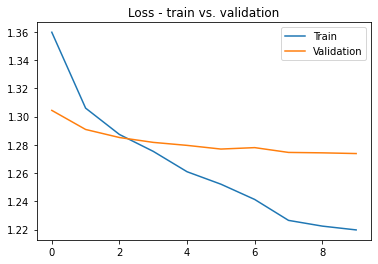

In [ ]:
plt.plot(results["train_loss"], label="Train")
plt.plot(results["test_loss"], label="Validation")
plt.legend()
plt.title("Loss - train vs. validation")
plt.show()

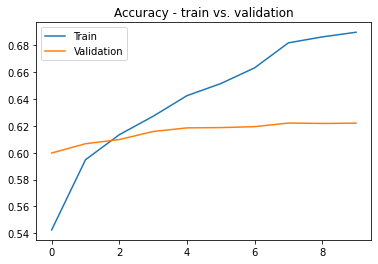

In [ ]:
plt.plot(results["train_acc"], label="Train")
plt.plot(results["test_acc"], label="Validation")
plt.legend()
plt.title("Accuracy - train vs. validation")
plt.show()